# Critical Transitions

Implementation of "Topology Data Analysis Of Critical Transitions In Financial Networks" by Marian Gidea, 2017. arXiv:1701.06081v1 [q-fin.MF]

**To Investigate**

Rolling Baseline
Make normalization independent of the time-frame
Daily updating
Local renormalization
Put/Call Ratio or other signals
Outside correlations; for instance, junk bonds with S&P500
Different short and long points
Superlevel sets. The problem is that a node should be distance 0 from itself.
Effects at higher topological dimensions
Kalman filter
Sampling and majority vote
Upper-quantile holdings or weighted correlations.
Periodicity to detect cointegration

In [1]:
import quandl
import numpy as np
import pandas as pd
import dionysus as d
from scipy.spatial.distance import squareform
from sklearn.preprocessing import MinMaxScaler
import os
import subprocess
import re

quandl.ApiConfig.api_key = # Your key here.

data_directory = # Your data directory here.

def quandl_return_symbol(s):
    """Rewrite a ticker symbol for the Quandl EOD Database."""
    # Quandl symbols have '.' and '-' replaced with '_'.
    s = re.sub('[.-]','_',s)
    # EOD is the dataset and .4 is the column containing closing prices.
    s = 'EOD/' + s + '.4'
    return s

def get_returns(symbols, start_date='2016-12-30', end_date=None, log_returns=False):
    """Get percent closing returns from Quandl for a list of symbols."""
    returns = quandl.get([quandl_return_symbol(s) for s in symbols],
                         start_date=start_date, end_date=end_date, transform='rdiff')
    
    # Convert to log-returns if necessary.
    # Log return is log of 1 + percent return. Compare the definitions.
    if log_returns:
        returns = np.log(returns + 1)
    
    # Rename the columns
    returns.columns = symbols
    # Check and drop symbols with missing data.
    dropped_returns = returns.dropna(axis=1)
    print('Missing data from symbols:' + str(list(set(returns.columns) - set(dropped_returns.columns))))
    return dropped_returns

def normalize_returns(returns, window=13):
    # Local renormalization. This is just computing a rolling z-score.
    x = returns
    r = x.rolling(window=window)
    m = r.mean()
    s = r.std(ddof=0)
    z = (x-m)/s
    z = z.dropna()
    return z

def quandl_short_symbol(s):
    """Rewrite a ticker symbol for the FINRA NYSE Database."""
    # Quandl symbols have '.' and '-' replaced with '_'.
    s = re.sub('[.-]','_',s)
    # FINRA/FNYX_ is the dataset and .1 is the column containing short volume.
    s = 'FINRA/FNYX_' + s + '.1'
    return s

def quandl_volume_symbol(s):
    """Rewrite a ticker symbol for the FINRA NYSE Database."""
    # Quandl symbols have '.' and '-' replaced with '_'.
    s = re.sub('[.-]','_',s)
    # FINRA/FNYX_ is the dataset and .3 is the column containing total volume.
    s = 'FINRA/FNYX_' + s + '.3'
    return s
    
    
def get_short_ratios(symbols, start_date='2016-12-30', end_date=None):
    short_vol = quandl.get([quandl_short_symbol(s) for s in symbols], start_date=start_date, end_date=end_date)
    short_vol.columns = symbols
    total_vol = quandl.get([quandl_volume_symbol(s) for s in symbols], start_date=start_date, end_date=end_date)
    total_vol.columns = symbols
    # Pandas division requires the column names to match.
    short_ratios = short_vol.div(total_vol)
    
    # Rename the columns
    short_ratios.columns = symbols
    # Check and drop symbols with missing data.
    dropped_ratios = short_ratios.dropna(axis=1)
    print('Missing data from symbols:' + str(list(set(short_ratios.columns) - set(dropped_ratios.columns))))
    return dropped_ratios


def compute_correlations(returns, window=15, method='pearson', direction='both'):
    """Compute rolling correlations for a dataframe containing returns."""
    dates = []
    cors = []
    
    # Whether to use ordinary, downside, or upside returns.
    if direction == 'both': pass
    elif direction == 'down': returns[returns > 0] = 0
    elif direction == 'up': returns[returns < 0 ] = -0
    
    for k in range(len(returns)-window+1):
        window_returns = returns[k:k+window]
        date = returns.index[k+window-1].strftime('%Y-%m-%d') # On the first day with window 4, it would be index 3, which is the fourth day.
        # print(date)
        dates.append(date)
        c = window_returns.corr(method=method)
        cors.append(c)
    correlations = pd.concat(cors,keys=dates)
    return correlations

def distance(c, sets = 'sublevel'):
    """Compute distances from correlations. Choose sublevel sets or superlevel sets."""
    d = np.sqrt(2*(1-np.round(c,2)))
    
    if sets == 'sublevel':
        return d
    elif sets == 'superlevel': # Broken.
        return 2 - d
    
def compute_distances(correlations, sets = 'sublevel'):
    """Apply the distance function to each correlation in a dataframe."""
    distances = distance(correlations, sets)
    return distances

def compute_ripser_diagrams(distance_matrix, maxdimension, maxdistance):
    """Computes the peristence diagrams using Ripser.
    Takes a distance matrix and returns a list of persistence points ordered by dimension."""

    # Save the distances into a temporary file for Ripser to read.
    np.savetxt('temp.distance', distance_matrix, delimiter=',')
    
    # Loading persistence files from Ripser into Dionysus
    temp_distance = 'PATH/temp.distance'
    subprocess.call('/bin/ripser/ripser PATH/temp.distance --format distance --dim ' + str(maxdimension) + ' --threshold ' + str(maxdistance) + ' > PATH/temp.persistence', shell=True)
    
    diagrams = []
    current = []

    for line in open('temp.persistence'):
        point1 = re.match(' \[(.*),([^ ]*)\)', line)
        point2 = re.match(' \[(.*), \)', line)
        if line.startswith('persistence'):
            diagrams.append(current)
            current = []
        elif point1:
            gps = point1.groups()
            point = tuple([float(x) for x in gps])
            #print(point)
            current.append(point)
        elif point2:
            gps = point2.groups()
            point = tuple([float(gps[0]), float('inf')])
            #print(point)
            current.append(point)
    del diagrams[0] # The first diagram is empty because of awkward parsing. Improve.
    os.remove('temp.distance') # Cleanup
    os.remove('temp.persistence')
    return diagrams


def convert_to_dionysus(diagrams):
    """Converts a diagram in list form to a Dionysus object."""
    return [d.Diagram(diag) for diag in diagrams]

def compute_dionysus_diagram(distance_matrix, maxdimension, maxdistance):
    """Compute the persistence diagrams as a Dionysus object."""
    diagrams = compute_ripser_diagrams(distance_matrix, maxdimension, maxdistance)
    diagrams = convert_to_dionysus(diagrams)
    return diagrams

def compute_persistence_diagrams(distances, maxdimension=2, maxdistance=2.5):
    """Compute persistence diagrams from a dataframe of distance matricies."""
    diagrams = []
    index = distances.index.levels[0] # This is the dates.
    for date in index:
        #print(date)
        diag = compute_ripser_diagrams(distances.loc[date], maxdimension, maxdistance)
        diagrams.append(diag)
    diagrams = pd.DataFrame(diagrams, index)
    dionysus_diagrams = diagrams.apply(convert_to_dionysus)
    return dionysus_diagrams

def compute_base_diagram(fill, dim, maxdimension=2, maxdistance=2.5):
    """Compute baseline diagrams.
    fill is the correlation to fill the array with, n is the square dimension,
    pdim is the max persistence dimension, and pdist is the max persistence distance."""
    e = np.empty((dim,dim))
    e.fill(fill)
    np.fill_diagonal(e,1.0)
    dists = distance(e)
    diagrams = compute_dionysus_diagram(dists, maxdimension, maxdistance)
    return diagrams

def compute_wasserstein_distances(base, diagrams, q=10):
    """Compute the series of Wasserstein distances from some baseline for a given dimension.
    Pass in list of baseline diagrams and a series of Dionysus diagrams, with q as the Wasserstein paramater."""
    w_distances = []
    for k in range(len(diagrams.columns)): # Iterate over the dimensions of diagrams. First column is dim 0, etc.
        # Need better checking on this. There could be empty dimensions?
        wdists = diagrams[k].apply(lambda x: d.wasserstein_distance(base[k], x, q=q))
        w_distances.append(wdists)
    w_distances = pd.concat(w_distances, axis=1)
    return w_distances

# def compute_wasserstein_distances(base, diagrams, q=10):
#     """Compute the series of Wasserstein distances from some baseline for a given dimension.
#     Pass in list of baseline diagrams and a series of Dionysus diagrams, with q as the Wasserstein paramater."""
#     w_distances = []
#     for k in range(len(diagrams.columns)): # Iterate over the dimensions of diagrams. First column is dim 0, etc.
#         wdists = []
#         dates = []
#         window = 30
#         for l in range(len(diagrams[k])-window+1):
#             base = diagrams[k][l]
#             diag = diagrams[k][l+window-1]
#             date = diagrams.index[l+window-1]
#             dates.append(date)
#             dist = d.wasserstein_distance(base,diag,q=q)
#             wdists.append(dist)
#         w_distances.append(pd.DataFrame(wdists,index=dates))
#     w_distances = pd.concat(w_distances, axis=1)
#     return w_distances

def normalize_distances(distances, decimals=3, inverse=False):
    """Normalize a dataframe of distance series to (0,1). If inverse is true, multiply the series by -1 before transforming."""
    i = -1 if inverse else 1
    normalized_distances = []
    for k in range(len(distances.columns)):
        scaler = MinMaxScaler(feature_range=(0,1))
        scaler = scaler.fit(i*distances[k].reshape(-1,1))
        normalized = scaler.transform(i*distances[k].reshape(-1,1))
        #normalized = normalized.flatten() # Why this?
        normalized = np.round(normalized, decimals=decimals)
        index = distances.index
        normalized = pd.DataFrame(normalized, index=index)
        normalized_distances.append(normalized)
    normalized_distances = pd.concat(normalized_distances, axis=1)
    return normalized_distances



# The main function of the library. Compute a normalized series of distances given a list of asset symbols.

def compute_distance_series(symbols, start_date='2016-12-30', end_date=None, log_returns=False, normalize=False,
                            window=15, method='pearson', direction='both', 
                            sets='sublevel', persistence_dim=1, 
                            wasserstein=10, base='anti'):
    """Base should either be 'anti' or a date."""
    print('Getting returns.')
    returns = get_returns(symbols, start_date=start_date, end_date=end_date, log_returns=log_returns)
    if normalize:
        returns = normalize_returns(returns, window=13)
    
    print('Computing correlations.')
    correlations = compute_correlations(returns, window=window, method=method, direction = direction)
    print('Computing distances.')
    distances = compute_distances(correlations, sets=sets)
    print('Computing diagrams')
    diagrams = compute_persistence_diagrams(distances, maxdimension = persistence_dim)
    
    dim = len(returns.columns)
    if base == 'anti':
        base_diagram = compute_base_diagram(-1, dim=dim, maxdimension = persistence_dim)
        inverse = True
    else:
        base_diagram = diagrams.loc[base]
        inverse = False
    print('Computing wasserstein distances.')
    wasserstein_distances = compute_wasserstein_distances(base_diagram, diagrams, q=wasserstein)
    
    print('Normalizing series.')
    distance_series = normalize_distances(wasserstein_distances, inverse=inverse)
    return distance_series

def compute_short_series(symbols, start_date='2016-12-30', end_date=None, 
                         window=15, method='pearson', 
                         sets='sublevel', persistence_dim=1, wasserstein=10, base='anti'):
    print('Getting data.')
    short_ratios = get_short_ratios(symbols, start_date=start_date, end_date=end_date)
    print('Computing correlations.')
    correlations = compute_correlations(short_ratios, window=window, method=method)
    print('Computing distances.')
    distances = compute_distances(correlations, sets=sets)
    print('Computing diagrams')
    diagrams = compute_persistence_diagrams(distances, maxdimension = persistence_dim)
    
    dim = len(short_ratios.columns)
    if base == 'anti':
        base_diagram = compute_base_diagram(-1, dim=dim, maxdimension = persistence_dim)
    else: # In this case it is a date.
        base_diagram = diagrams.loc[base]
    
    print('Computing wasserstein distances.')
    wasserstein_distances = compute_wasserstein_distances(base_diagram, diagrams, q=wasserstein)
    print('Normalizing series.')
    distance_series = normalize_distances(wasserstein_distances, inverse=True)
    return distance_series

In [2]:
import matplotlib.pyplot as plt
# Set the default figure size.
plt.rcParams["figure.figsize"] = [20,12]

In [3]:
# S&P 500
# ETF: SPY
SP500_symbols = ['ABT', 'ABBV', 'ACN', 'ACE', 'ADBE', 'ADT', 'AAP', 'AES', 'AET', 'AFL', 'AMG', 'A', 'GAS', 'APD', 'ARG', 'AKAM', 'AA', 'AGN', 'ALXN', 'ALLE', 'ADS', 'ALL', 'ALTR', 'MO', 'AMZN', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AMP', 'ABC', 'AME', 'AMGN', 'APH', 'APC', 'ADI', 'AON', 'APA', 'AIV', 'AMAT', 'ADM', 'AIZ', 'T', 'ADSK', 'ADP', 'AN', 'AZO', 'AVGO', 'AVB', 'AVY', 'BHI', 'BLL', 'BAC', 'BK', 'BCR', 'BXLT', 'BAX', 'BBT', 'BDX', 'BBBY', 'BRK-B', 'BBY', 'BLX', 'HRB', 'BA', 'BWA', 'BXP', 'BSK', 'BMY', 'BRCM', 'BF-B', 'CHRW', 'CA', 'CVC', 'COG', 'CAM', 'CPB', 'COF', 'CAH', 'HSIC', 'KMX', 'CCL', 'CAT', 'CBG', 'CBS', 'CELG', 'CNP', 'CTL', 'CERN', 'CF', 'SCHW', 'CHK', 'CVX', 'CMG', 'CB', 'CI', 'XEC', 'CINF', 'CTAS', 'CSCO', 'C', 'CTXS', 'CLX', 'CME', 'CMS', 'COH', 'KO', 'CCE', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CSC', 'CAG', 'COP', 'CNX', 'ED', 'STZ', 'GLW', 'COST', 'CCI', 'CSX', 'CMI', 'CVS', 'DHI', 'DHR', 'DRI', 'DVA', 'DE', 'DLPH', 'DAL', 'XRAY', 'DVN', 'DO', 'DTV', 'DFS', 'DISCA', 'DISCK', 'DG', 'DLTR', 'D', 'DOV', 'DOW', 'DPS', 'DTE', 'DD', 'DUK', 'DNB', 'ETFC', 'EMN', 'ETN', 'EBAY', 'ECL', 'EIX', 'EW', 'EA', 'EMC', 'EMR', 'ENDP', 'ESV', 'ETR', 'EOG', 'EQT', 'EFX', 'EQIX', 'EQR', 'ESS', 'EL', 'ES', 'EXC', 'EXPE', 'EXPD', 'ESRX', 'XOM', 'FFIV', 'FB', 'FAST', 'FDX', 'FIS', 'FITB', 'FSLR', 'FE', 'FSIV', 'FLIR', 'FLS', 'FLR', 'FMC', 'FTI', 'F', 'FOSL', 'BEN', 'FCX', 'FTR', 'GME', 'GPS', 'GRMN', 'GD', 'GE', 'GGP', 'GIS', 'GM', 'GPC', 'GNW', 'GILD', 'GS', 'GT', 'GOOGL', 'GOOG', 'GWW', 'HAL', 'HBI', 'HOG', 'HAR', 'HRS', 'HIG', 'HAS', 'HCA', 'HCP', 'HCN', 'HP', 'HES', 'HPQ', 'HD', 'HON', 'HRL', 'HSP', 'HST', 'HCBK', 'HUM', 'HBAN', 'ITW', 'IR', 'INTC', 'ICE', 'IBM', 'IP', 'IPG', 'IFF', 'INTU', 'ISRG', 'IVZ', 'IRM', 'JEC', 'JBHT', 'JNJ', 'JCI', 'JOY', 'JPM', 'JNPR', 'KSU', 'K', 'KEY', 'GMCR', 'KMB', 'KIM', 'KMI', 'KLAC', 'KSS', 'KRFT', 'KR', 'LB', 'LLL', 'LH', 'LRCX', 'LM', 'LEG', 'LEN', 'LVLT', 'LUK', 'LLY', 'LNC', 'LLTC', 'LMT', 'L', 'LOW', 'LYB', 'MTB', 'MAC', 'M', 'MNK', 'MRO', 'MPC', 'MAR', 'MMC', 'MLM', 'MAS', 'MA', 'MAT', 'MKC', 'MCD', 'MHFI', 'MCK', 'MJN', 'MMV', 'MDT', 'MRK', 'MET', 'KORS', 'MCHP', 'MU', 'MSFT', 'MHK', 'TAP', 'MDLZ', 'MON', 'MNST', 'MCO', 'MS', 'MOS', 'MSI', 'MUR', 'MYL', 'NDAQ', 'NOV', 'NAVI', 'NTAP', 'NFLX', 'NWL', 'NFX', 'NEM', 'NWSA', 'NEE', 'NLSN', 'NKE', 'NI', 'NE', 'NBL', 'JWN', 'NSC', 'NTRS', 'NOC', 'NRG', 'NUE', 'NVDA', 'ORLY', 'OXY', 'OMC', 'OKE', 'ORCL', 'OI', 'PCAR', 'PLL', 'PH', 'PDCO', 'PAYX', 'PNR', 'PBCT', 'POM', 'PEP', 'PKI', 'PRGO', 'PFE', 'PCG', 'PM', 'PSX', 'PNW', 'PXD', 'PBI', 'PCL', 'PNC', 'RL', 'PPG', 'PPL', 'PX', 'PCP', 'PCLN', 'PFG', 'PG', 'PGR', 'PLD', 'PRU', 'PEG', 'PSA', 'PHM', 'PVH', 'QRVO', 'PWR', 'QCOM', 'DGX', 'RRC', 'RTN', 'O', 'RHT', 'REGN', 'RF', 'RSG', 'RAI', 'RHI', 'ROK', 'COL', 'ROP', 'ROST', 'RLC', 'R', 'CRM', 'SNDK', 'SCG', 'SLB', 'SNI', 'STX', 'SEE', 'SRE', 'SHW', 'SIAL', 'SPG', 'SWKS', 'SLG', 'SJM', 'SNA', 'SO', 'LUV', 'SWN', 'SE', 'STJ', 'SWK', 'SPLS', 'SBUX', 'HOT', 'STT', 'SRCL', 'SYK', 'STI', 'SYMC', 'SYY', 'TROW', 'TGT', 'TEL', 'TE', 'TGNA', 'THC', 'TDC', 'TSO', 'TXN', 'TXT', 'HSY', 'TRV', 'TMO', 'TIF', 'TWX', 'TWC', 'TJK', 'TMK', 'TSS', 'TSCO', 'RIG', 'TRIP', 'FOXA', 'TSN', 'TYC', 'UA', 'UNP', 'UNH', 'UPS', 'URI', 'UTX', 'UHS', 'UNM', 'URBN', 'VFC', 'VLO', 'VAR', 'VTR', 'VRSN', 'VZ', 'VRTX', 'VIAB', 'V', 'VNO', 'VMC', 'WMT', 'WBA', 'DIS', 'WM', 'WAT', 'ANTM', 'WFC', 'WDC', 'WU', 'WY', 'WHR', 'WFM', 'WMB', 'WEC', 'WYN', 'WYNN', 'XEL', 'XRX', 'XLNX', 'XL', 'XYL', 'YHOO', 'YUM', 'ZBH', 'ZION', 'ZTS']

# Dow-Jones
# ETF: DIA
DJIA_symbols = ['BA','GS','MMM','UNH','HD','MCD','AAPL','IBM','JNJ','CAT','TRV','UTX','CVX','V','JPM','DIS','AXP','WMT','PG','XOM','MSFT','DWDP','MRK','NKE','VZ','KO','INTC','PFE','CSCO','GE']

# NASDAQ
# ETF: QQQ
NASDAQ_symbols = ['AMZN', 'CMCSA', 'PCLN', 'NFLX', 'CHTR', 'SBUX', 'TSLA', 'MAR', 'JD', 'FOXA', 'SIRI', 'ROST', 'DLTR', 'CTRP', 'FOX', 'EXPE', 'ORLY', 'LBTYK', 'WYNN', 'NCLH', 'ULTA', 'HAS', 'DISH', 'QVCA', 'VIAB', 'TSCO', 'LBTYA', 'LVNTA', 'DISCK', 'DISCA', 'LILAK', 'LILA', 'KHC', 'WBA', 'COST', 'MDLZ', 'MNST', 'AMGN', 'GILD', 'CELG', 'BIIB', 'REGN', 'ISRG', 'VRTX', 'ESRX', 'ILMN', 'ALXN', 'INCY', 'CERN', 'MYL', 'ALGN', 'BMRN', 'IDXX', 'XRAY', 'HSIC', 'HOLX', 'SHPG', 'CSX', 'PCAR', 'AAL', 'CTAS', 'VRSK', 'FAST', 'JBHT', 'AAPL', 'MSFT', 'FB', 'GOOG', 'GOOGL', 'INTC', 'CSCO', 'NVDA', 'AVGO', 'TXN', 'PYPL', 'ADBE', 'QCOM', 'BIDU', 'AMAT', 'ADP', 'ATVI', 'MU', 'CTSH', 'EBAY', 'INTU', 'EA', 'LRCX', 'ADI', 'FISV', 'ADSK', 'WDC', 'PAYX', 'MCHP', 'NTES', 'SYMC', 'SWKS', 'CHKP', 'XLNX', 'KLAC', 'MXIM', 'CA', 'CTXS', 'STX', 'MELI', 'AKAM', 'TMUS', 'VOD']


# Real Estate
# ETF: IYR
IYR_symbols = ['AMT', 'SPG', 'CCI', 'EQIX', 'PLD', 'PSA', 'WY', 'AVB', 'EQR', 'HCN', 'DLR', 'VTR', 'BXP', 'SBAC', 'ESS', 'O', 'HST', 'NLY', 'GGP', 'VNO', 'CBG', 'HCP', 'ARE', 'MAA', 'IRM', 'UDR', 'DRE', 'EXR', 'SLG', 'REG', 'FRT', 'CPT', 'AGNC', 'KIM', 'ELS', 'VER', 'WPC', 'GLPI', 'SUI', 'KRC', 'CLNS', 'AIV', 'FCEA', 'LPT', 'OHI', 'DEI', 'NNN', 'HTA', 'JLL', 'LAMR', 'ACC', 'STWD', 'BRX', 'DCT', 'CONE', 'NRZ', 'HIW', 'HPP', 'HHC', 'AMH', 'MPW', 'GPT', 'SFR', 'CUBE', 'HPT', 'RLGY', 'EPR', 'SNH', 'PK', 'STOR', 'APLE', 'HR', 'RLJ', 'RYN', 'CUZ', 'WRI', 'COR', 'LSI', 'SHO', 'SRC', 'EQC', 'FR', 'SBRA', 'TWO', 'CIM', 'RHP', 'MFA', 'OUT', 'PGRE', 'LHO', 'GEO', 'OFC', 'EGP', 'DOC', 'NHI', 'BDN', 'TCO', 'CXW', 'BXMT', 'JBGS', 'UNIT', 'RPAI', 'PDM', 'EDR', 'WRE', 'UE', 'CXP', 'PEB', 'DDR', 'SKT', 'AKR', 'XHR', 'LXP', 'DRH', 'PCH', 'ALEX', 'CLI', 'IVR', 'QCP', 'KRG', 'WPG', 'FCPT', 'CBL', 'MAC']

# Finance
# ETF: XLF
XLF_symbols = ['BRK.B', 'JPM', 'BAC', 'WFC', 'C', 'GS', 'USB', 'CB', 'MS', 'AXP', 'PNC', 'BLK', 'AIG', 'MET', 'SCHW', 'BK', 'PRU', 'CME', 'COF', 'SPGI', 'MMC', 'BBT', 'ICE', 'AON', 'TRV', 'STT', 'ALL', 'AFL', 'STI', 'PGR', 'MTB', 'DFS', 'SYF', 'MCO', 'AMP', 'TROW', 'WLTW', 'FITB', 'NTRS', 'HIG', 'KEY', 'CFG', 'RF', 'PFG', 'LNC', 'HBAN', 'IVZ', 'BEN', 'CMA', 'L', 'CBOE', 'ETFC', 'UNM', 'CINF', 'AJG', 'RJF', 'AMG', 'XL', 'RE', 'ZION', 'TMK', 'NDAQ', 'LUK', 'PBCT', 'BHF', 'AIZ', 'NAVI']

# Consumer Discretionary
# ETF: XLY
XLY_symbols = ['AMZN', 'HD', 'CMCSA', 'DIS', 'MCD', 'PCLN', 'NFLX', 'SBUX', 'TWX', 'NKE', 'LOW', 'CHTR', 'GM', 'F', 'TJX', 'MAR', 'TGT', 'FOXA', 'CCL.U', 'DLPH', 'YUM', 'ROST', 'VFC', 'DLTR', 'DG', 'RCL', 'CBS', 'NWL', 'ORLY', 'EXPE', 'AZO', 'MHK', 'OMC', 'MGM', 'DHI', 'BBY', 'HLT', 'KMX', 'GPC', 'LEN', 'ULTA', 'WHR', 'WYNN', 'LKQ', 'COH', 'FOX', 'LB', 'WYN', 'DISH', 'HAS', 'BWA', 'DRI', 'PVH', 'NCLH', 'TIF', 'VIAB', 'GT', 'HOG', 'HBI', 'PHM', 'IPG', 'SNI', 'KSS', 'KORS', 'TSCO', 'CMG', 'M', 'LEG', 'AAP', 'GRMN', 'GPS', 'HRB', 'MAT', 'NWSA', 'RL', 'JWN', 'TRIP', 'SIG', 'FL', 'DISCK', 'UAA', 'DISCA', 'UA']

# Gold
# ETF: GDX
GDX_symbols = ['NEM', 'ABX', 'FNV', 'GG', 'AEM', 'GOLD', 'RGLD', 'KGC', 'BVN', 'AU', 'GFI', 'IAG', 'SBGL', 'BTG', 'PAAS', 'AUY', 'PVG', 'NGD', 'HL', 'AGI', 'EGO', 'TAHO', 'CDE', 'SSRM', 'AG', 'SAND', 'HMY', 'FSM', 'MUX', 'WPM', 'KL', 'OR', 'KLDX']
# Unavailable: NCM, EVN, NST, CEY, CG, 2899, IGO, DGC, EDV, OGC, RRL, TXG

# Biotech
XBI_symbols = ['ALNY', 'JUNO', 'EXAS', 'NBIX', 'PBYI', 'BLUE', 'SRPT', 'SGEN', 'AVXS', 'CLVS', 'ABBV', 'UTHR', 'EXEL', 'ALKS', 'AMGN', 'BIIB', 'FOLD', 'BIVV', 'ACAD', 'IONS', 'TSRO', 'BMRN', 'VRTX', 'GILD', 'PTLA', 'REGN', 'INCY', 'ALXN', 'OPK', 'RDUS', 'CELG', 'ONCE', 'GBT', 'LGND', 'BPMC', 'LOXO', 'AGIO', 'ARRY', 'ESPR', 'DVAX', 'EGRX', 'ICPT', 'MYGN', 'CARA', 'RARE', 'FGEN', 'SAGE', 'IMMU', 'ACOR', 'IRWD', 'MDXG', 'EDIT', 'ARNA', 'XON', 'PRTA', 'ALDR', 'SGYP', 'HALO', 'IMGN', 'RXDX', 'RGEN', 'AMAG', 'PTCT', 'TGTX', 'EBS', 'SPPI', 'XLRN', 'AKAO', 'FLXN', 'FPRX', 'CALA', 'HRTX', 'FMI', 'MNTA', 'SGMO', 'ENTA', 'LJPC', 'INO', 'CHRS', 'LXRX', 'VNDA', 'INSM', 'KERX', 'EPZM', 'AKBA', 'CYTK', 'RTRX', 'AIMT', 'PGNX', 'ZIOP', 'RGNX', 'ACHN', 'XNCR', 'CTMX', 'MGNX', 'PDLI', 'BCRX', 'GHDX', 'ADRO', 'GERN']

# Alerian MLP
AMLP_symbols = ['MMP', 'EPD', 'ETP', 'MPLX', 'WPZ', 'PAA', 'BPL', 'WES', 'EQM', 'SEP', 'ANDX', 'EEP', 'DCP', 'TCP', 'NS', 'GEL', 'ENLK', 'SHLX', 'PSXP', 'AM', 'TEP', 'BWP', 'DM', 'RMP', 'HEP']

# Oil and Gas
XOP_symbols = ['CRZO', 'SM', 'WLL', 'OAS', 'HFC', 'CLR', 'MRO', 'PBF', 'WPX', 'SWN', 'CXO', 'RSPP', 'DVN', 'NFX', 'QEP', 'FANG', 'MUR', 'VLO', 'PXD', 'APC', 'XEC', 'EOG', 'MPC', 'OXY', 'COG', 'COP', 'HES', 'CHK', 'PDCE', 'EGN', 'PSX', 'GPOR', 'RRC', 'MTDR', 'PE', 'CPE', 'NBL', 'APA', 'ANDV', 'CVX', 'AR', 'XOM', 'EQT', 'LPI', 'DK', 'CRC', 'REN', 'CDEV', 'SRCI', 'XOG', 'SN', 'KOS', 'DNR', 'GPRE', 'INT', 'JAG', 'SGY', 'REI', 'TELL', 'REX', 'REGI', 'PARR', 'SD']

# Semi-Conductors
SOXL_symbols = ['ADI', 'AMAT', 'AMD', 'ASML', 'AVGO', 'CAVM', 'CRUS', 'CY', 'ENTG', 'IDTI', 'INTC', 'KLAC', 'LRCX', 'MCHP', 'MKSI', 'MPWR', 'MRVL', 'MSCC', 'MU', 'MXIM', 'NVDA', 'ON', 'QCOM', 'QRVO', 'SLAB', 'SWKS', 'TER', 'TSM', 'TXN', 'XLNX']


# Large-Cap
# ETF: IVV
IVV_symbols = ['AAPL', 'MSFT', 'FB', 'AMZN', 'JNJ', 'BRKB', 'JPM', 'XOM', 'GOOGL', 'GOOG', 'BAC', 'WFC', 'CVX', 'PG', 'PFE', 'T', 'UNH', 'C', 'V', 'VZ', 'HD', 'INTC', 'GE', 'KO', 'CSCO', 'CMCSA', 'DWDP', 'MRK', 'PM', 'PEP', 'DIS', 'ORCL', 'BA', 'ABBV', 'MMM', 'MA', 'IBM', 'MCD', 'WMT', 'AMGN', 'MO', 'NVDA', 'HON', 'MDT', 'GILD', 'BMY', 'AVGO', 'ABT', 'TXN', 'PCLN', 'UNP', 'UTX', 'SLB', 'ACN', 'GS', 'USB', 'ADBE', 'NFLX', 'UPS', 'LLY', 'CAT', 'PYPL', 'TMO', 'QCOM', 'SBUX', 'CELG', 'LMT', 'TWX', 'NKE', 'CVS', 'CB', 'NEE', 'MS', 'COST', 'AXP', 'LOW', 'CRM', 'PNC', 'BIIB', 'CHTR', 'CL', 'COP', 'WBA', 'MDLZ', 'DUK', 'AMAT', 'AMT', 'AET', 'GM', 'AGN', 'BLK', 'AIG', 'MET', 'GD', 'FDX', 'EOG', 'DHR', 'ANTM', 'SCHW', 'BK', 'MON', 'RTN', 'ADP', 'SO', 'NOC', 'D', 'SPG', 'CI', 'OXY', 'ITW', 'F', 'SYK', 'CSX', 'PRU', 'BDX', 'ATVI', 'CME', 'KHC', 'TJX', 'MU', 'COF', 'CTSH', 'PX', 'EMR', 'SPGI', 'DE', 'CCI', 'MMC', 'ISRG', 'KMB', 'BSX', 'BBT', 'JCI', 'PSX', 'ICE', 'AON', 'NSC', 'EXC', 'MAR', 'INTU', 'EBAY', 'AEP', 'STZ', 'HUM', 'TRV', 'VRTX', 'HPQ', 'HAL', 'EA', 'ETN', 'EQIX', 'STT', 'APD', 'ECL', 'KMI', 'PLD', 'ESRX', 'ALL', 'DAL', 'TGT', 'VLO', 'LRCX', 'ADI', 'AFL', 'LYB', 'WM', 'SHW', 'BAX', 'FIS', 'REGN', 'TEL', 'ZTS', 'PSA', 'LUV', 'PPG', 'ILMN', 'MCK', 'GIS', 'MPC', 'STI', 'PCG', 'SRE', 'GLW', 'PGR', 'CMI', 'ALXN', 'FOXA', 'CCL', 'FISV', 'APC', 'SYY', 'ADSK', 'ED', 'DLPH', 'WDC', 'ROP', 'YUM', 'WY', 'APH', 'DXC', 'PPL', 'EIX', 'MTB', 'PCAR', 'SWK', 'ROST', 'EL', 'PEG', 'DFS', 'AVB', 'XEL', 'SYF', 'EQR', 'PH', 'AMP', 'MCO', 'ZBH', 'HCN', 'ADM', 'PXD', 'ROK', 'IP', 'BCR', 'DLR', 'MNST', 'WMB', 'HPE', 'VFC', 'IR', 'TROW', 'CERN', 'FTV', 'HCA', 'DG', 'DLTR', 'WLTW', 'EW', 'VTR', 'COL', 'MCHP', 'A', 'FITB', 'RHT', 'WEC', 'RCL', 'AAL', 'CBS', 'MYL', 'TSN', 'PAYX', 'NTRS', 'CAH', 'OKE', 'HIG', 'KEY', 'NWL', 'FCX', 'DTE', 'ES', 'INCY', 'SYMC', 'SWKS', 'CXO', 'CFG', 'NEM', 'NUE', 'ORLY', 'RF', 'KR', 'BXP', 'DVN', 'PFG', 'EXPE', 'SBAC', 'XLNX', 'MTD', 'ESS', 'KLAC', 'LNC', 'CLX', 'AZO', 'MHK', 'OMC', 'HRS', 'VMC', 'Q', 'MGM', 'AME', 'DPS', 'CNC', 'INFO', 'LH', 'UAL', 'WAT', 'AWK', 'ALB', 'ETR', 'WRK', 'GPN', 'LVLT', 'ANDV', 'HBAN', 'K', 'IVZ', 'APA', 'BLL', 'RSG', 'DOV', 'TAP', 'DHI', 'BBY', 'AEE', 'MSI', 'O', 'ALGN', 'HLT', 'HSY', 'BEN', 'LLL', 'HST', 'IDXX', 'TXT', 'FE', 'XRAY', 'CMA', 'CAG', 'KMX', 'MLM', 'FAST', 'CMS', 'L', 'VRSK', 'GPC', 'TDG', 'NBL', 'EMN', 'EFX', 'SNPS', 'NLSN', 'HSIC', 'BHGE', 'CTAS', 'DGX', 'NOV', 'GGP', 'ABC', 'MAS', 'CBOE', 'CNP', 'VNO', 'FMC', 'CDNS', 'HCP', 'SJM', 'UNM', 'URI', 'LEN', 'ETFC', 'TSS', 'MKC', 'IFF', 'NTAP', 'PNR', 'CBG', 'CTXS', 'WHR', 'FTI', 'ULTA', 'COO', 'XYL', 'MRO', 'COH', 'WYNN', 'ARE', 'CHD', 'IT', 'LKQ', 'FOX', 'CINF', 'COG', 'ADS', 'ANSS', 'MAA', 'AJG', 'PKG', 'RMD', 'PRGO', 'HES', 'LB', 'BFB', 'CHRW', 'STX', 'KSU', 'HAS', 'WYN', 'RJF', 'DISH', 'XEC', 'EXPD', 'AMG', 'IRM', 'XL', 'GWW', 'BWA', 'FBHS', 'HOLX', 'ARNC', 'CA', 'DRI', 'EQT', 'DRE', 'UDR', 'CTL', 'LNT', 'PVH', 'EXR', 'NCLH', 'PNW', 'AMD', 'TIF', 'RE', 'SLG', 'VAR', 'JNPR', 'DVA', 'ZION', 'VRSN', 'WU', 'JBHT', 'REG', 'AVY', 'SNA', 'TMK', 'CPB', 'UHS', 'QRVO', 'AKAM', 'VIAB', 'AOS', 'FRT', 'CF', 'NI', 'SEE', 'NDAQ', 'GT', 'HOG', 'HBI', 'PHM', 'HRL', 'PKI', 'ALK', 'LUK', 'SNI', 'IPG', 'FFIV', 'KIM', 'ALLE', 'KSS', 'KORS', 'NRG', 'MOS', 'AES', 'TSCO', 'COTY', 'JEC', 'CMG', 'SCG', 'AIV', 'AYI', 'RHI', 'FLIR', 'PBCT', 'XRX', 'M', 'LEG', 'GRMN', 'MAC', 'AAP', 'SRCL', 'BHF', 'GPS', 'FLR', 'FLS', 'HP', 'NFX', 'PWR', 'HRB', 'AIZ', 'EVHC', 'CSRA', 'NWSA', 'MAT', 'JWN', 'RL', 'FL', 'TRIP', 'RRC', 'SIG', 'DISCK', 'NAVI', 'CHK', 'UAA', 'PDCO', 'UA', 'DISCA', 'NWS']

# Mid-Cap
IJH_symbols = ['TTWO', 'NVR', 'TFX', 'MSCI', 'CGNX', 'HII', 'CC', 'TRMB', 'SIVB', 'BR', 'IEX', 'RGA', 'STLD', 'ATO', 'INGR', 'LDOS', 'EWBC', 'CDK', 'SEIC', 'JKHY', 'CPT', 'UGI', 'MAN', 'TER', 'DPZ', 'WCG', 'ODFL', 'KEYS', 'Y', 'IPGP', 'STE', 'OA', 'ABMD', 'WR', 'PTC', 'GGG', 'WST', 'FDS', 'LII', 'ARW', 'LW', 'SBNY', 'OGE', 'AFG', 'CPRT', 'PII', 'RPM', 'CSL', 'GXP', 'KRC', 'HUBB', 'TOL', 'TTC', 'OSK', 'WRB', 'MKTX', 'SCI', 'THO', 'WAB', 'COHR', 'NDSN', 'JBLU', 'LOGM', 'HFC', 'PACW', 'JHG', 'DCI', 'TYL', 'WTR', 'LPT', 'NYCB', 'BIVV', 'OHI', 'LECO', 'FTNT', 'MSCC', 'DEI', 'NNN', 'ZBRA', 'TDY', 'EV', 'OLN', 'CFR', 'JLL', 'FAF', 'LAMR', 'BRO', 'OZRK', 'SNV', 'RS', 'ACC', 'STL', 'LYV', 'VVC', 'CRL', 'CTLT', 'ATR', 'ULTI', 'RNR', 'ACM', 'RGLD', 'GNTX', 'POST', 'CONE', 'DCT', 'HIW', 'KNX', 'HRC', 'CBSH', 'MDU', 'CY', 'SON', 'UTHR', 'EXP', 'AVT', 'WBS', 'CW', 'WSO', 'DNKN', 'JBL', 'POOL', 'SIX', 'ARRS', 'PNFP', 'WEX', 'NFG', 'VVV', 'ORI', 'BRCD', 'X', 'EGN', 'MPW', 'TRN', 'NATI', 'LFUS', 'AGCO', 'PB', 'CRI', 'TECH', 'BLKB', 'SLM', 'IDA', 'UMPQ', 'EME', 'FICO', 'GWR', 'FHN', 'WTFC', 'FNB', 'VSM', 'BIO', 'EPR', 'MDSO', 'R', 'WGL', 'SKX', 'DNB', 'CR', 'MPWR', 'HLS', 'TCBI', 'CASY', 'WWD', 'BC', 'MMS', 'DAN', 'ASH', 'HBHC', 'HPT', 'ROL', 'THG', 'SNH', 'BMS', 'WSM', 'LSTR', 'ITT', 'MASI', 'WPX', 'CLB', 'TDC', 'MUR', 'PTEN', 'MD', 'CLGX', 'SMG', 'LPX', 'RIG', 'TEX', 'SLAB', 'OGS', 'BCO', 'HR', 'NCR', 'CNK', 'PRI', 'SNX', 'FSLR', 'ASB', 'UBSI', 'MBFI', 'HE', 'CHFC', 'OI', 'SWX', 'HAIN', 'CUZ', 'THS', 'RYN', 'NEU', 'SABR', 'COR', 'IDTI', 'NJR', 'CBRL', 'CBT', 'EPC', 'LSI', 'POL', 'WRI', 'FR', 'KEX', 'HOMB', 'RBC', 'VMI', 'CNO', 'SBRA', 'SF', 'BOH', 'MSM', 'JCOM', 'DLX', 'DST', 'BKH', 'FLO', 'CRUS', 'VSAT', 'KMT', 'BDC', 'SXT', 'LM', 'PNM', 'TKR', 'TXRH', 'CABO', 'FULT', 'CNX', 'UMBF', 'LNCE', 'INCR', 'CREE', 'SAIC', 'LIVN', 'TECD', 'LHO', 'CATY', 'GEO', 'ILG', 'WAFD', 'MANH', 'NUS', 'AN', 'TUP', 'OFC', 'AKRX', 'VLY', 'ENS', 'CAA', 'PBF', 'TPX', 'BBBY', 'CAR', 'CIEN', 'MNK', 'JACK', 'TCF', 'NUVA', 'KMPR', 'TCO', 'SAFM', 'CXW', 'VSH', 'JBGS', 'MOH', 'ACIW', 'UNIT', 'CLH', 'KLXI', 'NWE', 'MSA', 'DY', 'ENR', 'UFS', 'FII', 'BXS', 'WEN', 'TGNA', 'ATI', 'AMCX', 'NTCT', 'CHDN', 'ACHC', 'AAN', 'IDCC', 'SWN', 'GHC', 'TDS', 'PBI', 'HELE', 'KBR', 'TPH', 'EDR', 'MTX', 'MUSA', 'UE', 'ESL', 'AHL', 'LANC', 'INT', 'PBH', 'MDRX', 'NYT', 'JWA', 'CVG', 'MTDR', 'AEO', 'CRS', 'MIK', 'GATX', 'BIG', 'GVA', 'SBH', 'SKT', 'SFM', 'DKS', 'TRMK', 'DECK', 'CMP', 'CMC', 'IBOC', 'ATGE', 'KBH', 'LPNT', 'GMED', 'GPOR', 'CVLT', 'PAY', 'SLGN', 'ESV', 'PCH', 'MLHR', 'MDP', 'ALEX', 'WOR', 'CPE', 'MCY', 'HYH', 'URBN', 'CLI', 'ACXM', 'GME', 'UNFI', 'QEP', 'ODP', 'CAKE', 'BID', 'CTB', 'OII', 'BWLD', 'SM', 'PZZA', 'CARS', 'NBR', 'GNW', 'OMI', 'WERN', 'SAM', 'HNI', 'PLT', 'DBD', 'EAT', 'QCP', 'RDC', 'WPG', 'DRQ', 'GEF', 'KN', 'ENDP', 'DDD', 'DNOW', 'SYNA', 'HSNI', 'SPN', 'DDS', 'THC', 'DO', 'AVP', 'ISCA', 'DF', 'FTR', 'TR']

# Small-Cap
# ETF: IJR
IJR_symbols = ['MKSI', 'ALE', 'HCSG', 'LITE', 'SR', 'IBKR', 'NKTR', 'AEIS', 'B', 'CACI', 'JBT', 'SIGI', 'CMD', 'CHE', 'STMP', 'AVA', 'VAC', 'LCII', 'FFIN', 'FIVE', 'NEOG', 'EGP', 'EVR', 'PDCE', 'PRA', 'FCFS', 'IART', 'LGND', 'ASGN', 'NGVT', 'SANM', 'DAR', 'GBCI', 'FUL', 'MOGA', 'TTEK', 'WWW', 'ICUI', 'CBU', 'BCPC', 'ITRI', 'LAD', 'PSB', 'SJI', 'TREX', 'SMTC', 'ROG', 'WAGE', 'GDOT', 'AIT', 'HI', 'ONB', 'COLB', 'CVBF', 'HQY', 'UNF', 'HAE', 'GWB', 'IIVI', 'AJRD', 'HOPE', 'SKYW', 'KFY', 'MRCY', 'FMBI', 'EE', 'ABM', 'FNGN', 'SHOO', 'AKR', 'SFNC', 'MYGN', 'SGMS', 'CCMP', 'TIVO', 'SLCA', 'BLD', 'BRKS', 'UFPI', 'RLI', 'BYD', 'OLLI', 'POWI', 'PRLB', 'BGS', 'LXP', 'DRH', 'DORM', 'CCOI', 'VIAV', 'EXLS', 'PLXS', 'SSD', 'PRGS', 'UCBI', 'PLAY', 'MATW', 'CWT', 'SEM', 'AMN', 'SUPN', 'MGLN', 'ROIC', 'AWR', 'OMCL', 'JJSF', 'KWR', 'MLI', 'AXE', 'INDB', 'EFII', 'TREE', 'PLCE', 'BANR', 'KS', 'MMSI', 'EXPO', 'AKS', 'NWN', 'WTS', 'MDCO', 'MTH', 'SFBS', 'CPS', 'BRC', 'ABCB', 'LTC', 'SRCI', 'HA', 'NSP', 'HMN', 'AEL', 'MDR', 'FLOW', 'NWBI', 'FELE', 'IRBT', 'ALGT', 'ARI', 'FWRD', 'NPO', 'FFBC', 'HSC', 'MEI', 'NBTB', 'AIN', 'CHSP', 'PFS', 'VG', 'PENN', 'LTXB', 'KALU', 'FOXF', 'INN', 'PPBI', 'RH', 'QLYS', 'SPPI', 'AAT', 'FCN', 'MNRO', 'OSIS', 'HMSY', 'CBM', 'NSIT', 'AAWW', 'INGN', 'HF', 'SCL', 'KLIC', 'SAIA', 'CORE', 'ATU', 'KAMN', 'WDFC', 'WABC', 'NTRI', 'DSW', 'TGI', 'AXL', 'BOBE', 'GPI', 'WD', 'ESE', 'EIG', 'BHE', 'KRG', 'KRA', 'MINI', 'MDC', 'NTGR', 'FCPT', 'RMBS', 'IOSP', 'EBIX', 'PATK', 'STBA', 'BOFI', 'UVV', 'NP', 'CTRE', 'AMWD', 'TTMI', 'GBX', 'FCF', 'ITGR', 'SFLY', 'TILE', 'EBS', 'CSGS', 'MXL', 'AAON', 'IBP', 'FIX', 'APOG', 'ELY', 'WGO', 'RGEN', 'GTLS', 'SCSS', 'AMED', 'CUB', 'FN', 'BPFH', 'OCLR', 'IPXL', 'ASIX', 'BCC', 'WNC', 'GIMO', 'ADC', 'SXI', 'LZB', 'CBL', 'CALM', 'CVCO', 'TVTY', 'DIOD', 'BABY', 'CNMD', 'NAVG', 'PLUS', 'HUBG', 'CAL', 'MSTR', 'SWM', 'VREX', 'BMI', 'FSS', 'CENTA', 'SPXC', 'MDXG', 'THRM', 'VVI', 'TNC', 'CNSL', 'WETF', 'AIR', 'VSTO', 'AZZ', 'PRAA', 'OSUR', 'TIME', 'RAVN', 'BRKL', 'ACOR', 'AMSF', 'RMAX', 'USCR', 'MANT', 'MATX', 'EPAY', 'HTLD', 'AAXN', 'CRZO', 'KEM', 'ECOL', 'SYKE', 'LABL', 'ABG', 'EGHT', 'CHCO', 'GOV', 'SCSC', 'CVGW', 'ENSG', 'EGOV', 'ABAX', 'JCP', 'BGG', 'AVAV', 'OXM', 'BCOR', 'OIS', 'LHCG', 'XPER', 'BEL', 'CCC', 'GIII', 'MNTA', 'SEDG', 'WDR', 'CHS', 'SONC', 'TMP', 'SHLM', 'FSP', 'BGC', 'SCHL', 'NSA', 'TPRE', 'CATM', 'ARR', 'VRTU', 'COKE', 'GNCMA', 'ROCK', 'IPCC', 'TBI', 'GES', 'ALG', 'HAFC', 'KOP', 'LDL', 'GCI', 'DEL', 'ADTN', 'RPT', 'LL', 'SAFT', 'IRDM', 'LGIH', 'ALOG', 'ANF', 'SBSI', 'LNN', 'DPLO', 'ACLS', 'ANDE', 'CEVA', 'STRA', 'ASTE', 'SSP', 'EXTN', 'IPHS', 'HLX', 'WING', 'NE', 'WWE', 'SPTN', 'FBP', 'WIRE', 'MTRN', 'CUDA', 'PJC', 'SPSC', 'UHT', 'INVA', 'UNT', 'UEIC', 'TYPE', 'PMC', 'GTY', 'RGR', 'BANC', 'STC', 'SMP', 'CIR', 'TRST', 'NBHC', 'BEAT', 'OFIX', 'MTSC', 'VRTS', 'CMO', 'DIN', 'RRGB', 'CTS', 'RTEC', 'IRT', 'VECO', 'CLDT', 'ARCB', 'CPF', 'AROC', 'UFCS', 'CBB', 'GLT', 'CUBI', 'ECPG', 'NEWM', 'USPH', 'LMNX', 'NFBK', 'SMCI', 'TLRD', 'CAMP', 'ANIK', 'UVE', 'KELYA', 'ETH', 'MHO', 'NR', 'HMST', 'CPLA', 'NX', 'IPAR', 'ITG', 'MRTN', 'AEGN', 'NCI', 'CKH', 'NMIH', 'CLW', 'CROX', 'LPSN', 'AAOI', 'SXC', 'CRAY', 'DFIN', 'CENX', 'BFS', 'PETS', 'PAHC', 'CASH', 'GPRE', 'NANO', 'CECO', 'PEI', 'PGTI', 'RRD', 'GFF', 'HT', 'ENTA', 'PRFT', 'TMST', 'COHU', 'MED', 'DCOM', 'CYH', 'LCI', 'CRY', 'QSII', 'ORIT', 'UBA', 'SHAK', 'AMPH', 'CYTK', 'FARO', 'PRSC', 'UFI', 'INTL', 'HSKA', 'ANGO', 'SSTK', 'AHH', 'PLAB', 'VIVO', 'SVU', 'RUTH', 'RYAM', 'JBSS', 'LKSD', 'ECHO', 'AVD', 'BJRI', 'TTEC', 'ATNI', 'EGL', 'HSTM', 'NPK', 'CRVL', 'AFAM', 'WLH', 'EXPR', 'LNTH', 'ESIO', 'LMAT', 'MPAA', 'AMAG', 'RGS', 'RCII', 'SAH', 'MYRG', 'EZPW', 'MHLD', 'GCO', 'KND', 'REX', 'CTRL', 'PARR', 'GHL', 'ANIP', 'ENVA', 'CMTL', 'DXPE', 'MCS', 'NLS', 'WSR', 'CCRN', 'BKE', 'TWI', 'IIIN', 'LION', 'MCRI', 'XOXO', 'TG', 'MYE', 'HVT', 'IVC', 'WRLD', 'SNCR', 'OPB', 'BKMU', 'HAYN', 'EGRX', 'FRGI', 'CDR', 'FORR', 'RECN', 'LMOS', 'MOV', 'BKS', 'DNR', 'OFG', 'FINL', 'HSII', 'DAKT', 'HZO', 'FOSL', 'PGNX', 'CENT', 'SRDX', 'FF', 'SUP', 'MTRX', 'ESND', 'HWKN', 'BH', 'VDSI', 'CHUY', 'EHTH', 'TISI', 'PKE', 'VRTV', 'VICR', 'SPOK', 'ASNA', 'CPSI', 'CLD', 'BBG', 'APEI', 'UIHC', 'ACET', 'CATO', 'HCI', 'DEPO', 'BELFB', 'TTS', 'ZUMZ', 'TTI', 'DSPG', 'ICON', 'RRTS', 'PERY', 'DGII', 'BRS', 'HIBB', 'FTK', 'LOCO', 'QNST', 'POWL', 'BNED', 'SENEA', 'SCMP', 'SCVL', 'FRAN', 'HLIT', 'GEOS', 'ORN', 'KOPN', 'KIRK', 'FTD', 'ERA', 'AGYS', 'TESO', 'ZEUS', 'GIFI', 'QHC', 'FRED', 'LQDT', 'LXU', 'RT', 'BGFV', 'PES', 'VRA', 'CRR', 'DHX', 'VSI', 'MCF', 'BBOX', 'GRB']

# Small-Cap Value
RZV_symbols = ['KELYA', 'MHO', 'RH', 'CMTL', 'EXTN', 'ESIO', 'QNST', 'ASIX', 'BCC', 'MTH', 'DPLO', 'GBX', 'ECPG', 'IVC', 'SEM', 'SENEA', 'SCSC', 'GCI', 'MDC', 'PMC', 'NSIT', 'WNC', 'SKYW', 'RRTS', 'AEL', 'NE', 'DAR', 'RGS', 'ARCB', 'UIHC', 'NEWM', 'UVV', 'ANF', 'BHE', 'SANM', 'AAWW', 'SAH', 'ITGR', 'GES', 'TBI', 'INTL', 'GPI', 'GIFI', 'AXL', 'LAD', 'CENX', 'AFAM', 'TPRE', 'HZO', 'ZEUS', 'PRSC', 'BANC', 'RRGB', 'ENVA', 'WRLD', 'CPS', 'HVT', 'PENN', 'PERY', 'BGG', 'TIME', 'ANDE', 'HUBG', 'GIII', 'IPCC', 'VRTU', 'LKSD', 'MHLD', 'GLT', 'VRTV', 'KIRK', 'AXE', 'BNED', 'FCN', 'GPRE', 'HSII', 'ECHO', 'ERA', 'MTRX', 'MYGN', 'ABG', 'SCVL', 'ESND', 'SIGI', 'KFY', 'AIR', 'UFCS', 'IRDM', 'MTRN', 'EZPW', 'CORE', 'STC', 'PLXS', 'SEDG', 'LHCG', 'COHU', 'HMN', 'EXPR', 'EIG', 'MANT', 'SCHL', 'BKS', 'OPB', 'AEGN', 'HCI', 'BGC', 'HMST', 'UFI', 'CAL', 'RRD', 'BRS', 'SYKE', 'LXU', 'CMO', 'ITG', 'KS', 'RYAM', 'PARR', 'FRED', 'CHSP', 'WIRE', 'FOSL', 'CROX', 'MOV', 'NAVG', 'KND', 'SPOK', 'GCO', 'ASNA', 'TMST', 'DXPE', 'OFG', 'CYH', 'CACI', 'WDR', 'CLW', 'KAMN', 'APEI', 'SAFT', 'POWL', 'RT', 'QHC', 'SXC', 'BGFV', 'DGII', 'RECN', 'FINL', 'SUP', 'ARR', 'SVU', 'CLD', 'FTD', 'JCP', 'VSI', 'CATO', 'BBOX']



The short way.

In [ ]:
ivv = compute_distance_series(IVV_symbols, start_date='2016-12-01', normalize=False,
                              window=15, method='pearson', direction='both',
                              base='2017-10-10',wasserstein=5)

The long way.

In [26]:
returns = get_returns(DJIA_symbols, start_date='2017-01-01')

Missing data from symbols:['DWDP']


In [69]:
norm_returns = normalize_returns(returns, window=13)

In [85]:
returns15 = returns.rolling(15).mean().dropna()

In [113]:
cors = compute_correlations(returns, window=7)

In [114]:
dists = compute_distances(cors)

In [115]:
diags = compute_persistence_diagrams(dists, maxdimension=1)

In [116]:
base = compute_base_diagram(-1, len(diags))

In [117]:
wdists = compute_wasserstein_distances(base, diags, q=2)

In [ ]:
dia = normalize_distances(wdists)

In [119]:
series = pd.concat([dia1, dia2], axis=1)

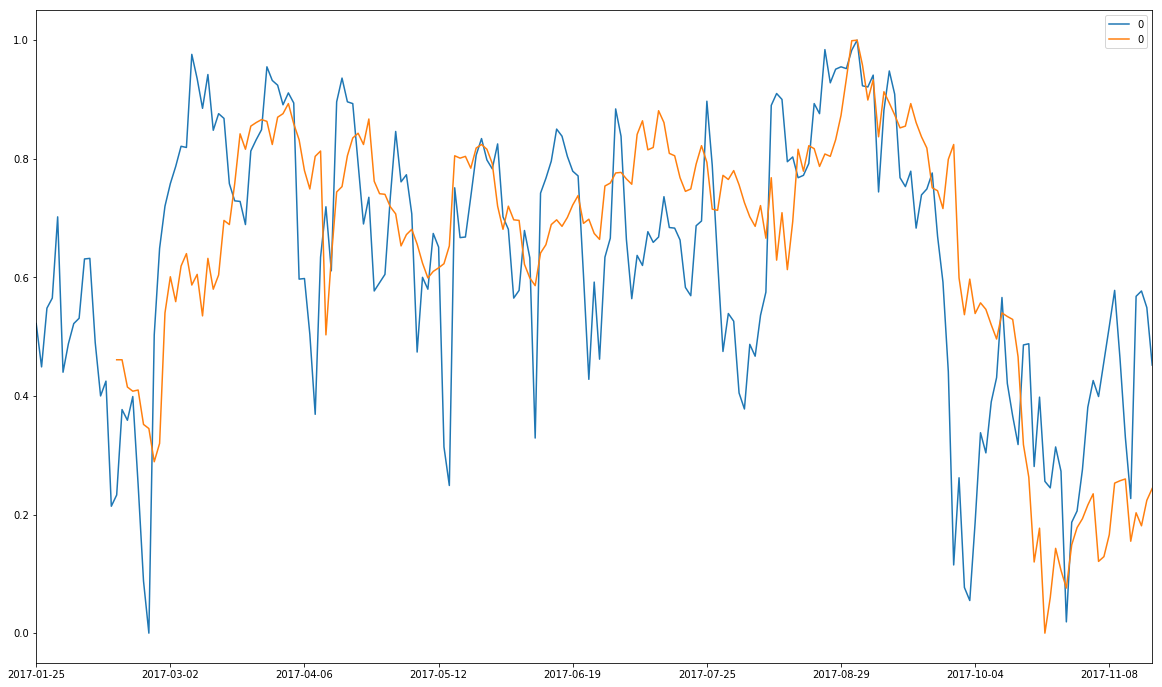

In [120]:
series.plot()
plt.show()